In [1]:

import sys
path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant/'
sys.path.append(path_to_quant)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [2]:
from matplotlib.patches import Rectangle

def add_inset(axes, j, i, plt, x1=200,x2=400,y1=400,y2=600):
    axin = axes[j,i].inset_axes([.4, .4, 0.6, 0.6])
    axin.set_xlim(x1, x2)
    axin.set_ylim(y1, y2)
    axin.imshow(plt)
    axes[j,i].indicate_inset_zoom(axin)
    axin.set_xticks([])
    axin.set_yticks([])
    border = Rectangle((0, 0), 5, 5, color='white', linewidth=5, fill=False, transform=axin.transAxes)
    axin.add_patch(border)
    
def add_scale_bar(size, img, plt):
    end = np.round(size/img.physical_pixel_sizes[2])
    for i in range(3):
        #plt[10:(10+int(end)),190:195,i] = 1
        plt[10:15,150:(150+int(end)),i] = 1
        
def plot_axis(axes, plt, j, i, size, img, collabs, rowlabs):
    add_scale_bar(size, img, plt)
    axes[j,i].imshow(plt, origin = 'lower')
    axes[j,i].set_xticks([])
    axes[j,i].set_yticks([])
    if j==0:
        axes[j,i].xaxis.set_label_position('top')
        axes[j,i].set_xlabel(collabs[i], fontsize=23)
    if i==0:
        axes[j,i].set_ylabel(rowlabs[j], fontsize=23)
        
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
from scipy.stats import ttest_ind
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from aicsimageio import AICSImage
from confocalQuant.segmentation import bgrnd_subtract, gamma_correct_image, extract_channels
import os 

def extract_sbatch_parameters(file_path):
    """
    Extract parameters from a Slurm sbatch script file and return them as a dictionary.

    Parameters:
    - file_path (str): Path to the sbatch script file.

    Returns:
    - dict: A dictionary containing the extracted parameters, where keys
            are parameter names and values are either single values or lists
            of values if parameters are specified in list form.
    """
    parameters = {}

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            # Ignore comments
            if line.startswith("#"):
                continue

            # Extract key-value pairs or parameters in list form
            parts = line.split()
            if len(parts) >= 2:
                key, *values = parts
                if '\\' in values:
                    # Handle parameters in the form of "--key value1 value2 \"
                    values = values[:values.index('\\')]
                parameters[key] = values
            elif len(parts) == 1:
                # Handle parameters in list form
                parameters.setdefault('list_parameters', []).extend(parts)

    return parameters

def plot_effect(data, condition, control, treatment, x_name):
    """
    Plot the effect of a treatment condition on the distribution of a variable.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the relevant data.
    - condition (str): Column name representing the treatment condition.
    - control (str): Value corresponding to the control group in the 'condition' column.
    - treatment (str): Value corresponding to the treatment group in the 'condition' column.
    - x_name (str): Column name representing the variable to be plotted.

    Returns:
    - None: The function only generates and displays the plot.
    """
    plt.figure(figsize=(10,10))
    index = (data[condition]==control) | (data[condition]==treatment)

    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.5, .85)})

    # assigning a graph to each ax
    sns.boxplot(data=data[index], x=x_name, y=condition,orient="h", ax=ax_box, hue=condition, width=0.5)
    sns.kdeplot(data=data[index], x=x_name, ax=ax_hist, hue=condition)
   
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    
def plot_by_well(data, name, treatment):
    """
    Plot a boxplot comparing the mean values of a variable by well condition.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the relevant data.
    - name (str): Column name representing the variable to be plotted.
    - treatment (str): Value corresponding to the treatment condition in the 'condition' column.

    Returns:
    - None: The function only generates and displays the boxplot with p-value annotation.
    """
    data['MeanValue'] = data.groupby('wellname')[name].transform('mean')

    temp = data[['condition', 'MeanValue']].drop_duplicates()
    temp = temp[(temp['condition']=='vehicle') | (temp['condition']==treatment)]

    ax = sns.boxplot(x='condition', y='MeanValue', data=temp)

    # Add p-value annotation
    grouped_data = temp.groupby('condition')['MeanValue']
    group_a = grouped_data.get_group('vehicle')
    group_b = grouped_data.get_group(treatment)

    t_stat, p_value = ttest_ind(group_a, group_b)

    # Annotate the plot with the p-value
    x_pos = 0.5  # Adjust the x-position as needed
    y_pos = max(ax.get_ylim())  # Place annotation at the top of the plot
    plt.text(x_pos, y_pos, f'P-Value: {p_value:.3f}', ha='center', va='center', color='red')

def plot_violin(data, name, colname, baseline, treatment):
    """
    Plot a violinplot comparing the distribution of a variable between two conditions.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the relevant data.
    - name (str): Column name representing the variable to be plotted.
    - colname (str): Column name representing the categorical variable for comparison.
    - baseline (str): Value corresponding to the baseline condition in the 'colname' column.
    - treatment (str): Value corresponding to the treatment condition in the 'colname' column.

    Returns:
    - None: The function only generates and displays the violinplot with a p-value annotation.
    """
    # Create a violinplot
    data2 = data[(data[colname]==baseline) | (data[colname]==treatment)]
    ax = sns.violinplot(x='condition', y=name, data=data2)

    # Add p-value annotation
    grouped_data = data2.groupby(colname)[name]
    group_a = grouped_data.get_group(baseline)
    group_b = grouped_data.get_group(treatment)

    t_stat, p_value = ttest_ind(group_a, group_b)

    # Annotate the plot with the p-value
    x_pos = 0.5  # Adjust the x-position as needed
    y_pos = max(ax.get_ylim())  # Place annotation at the top of the plot
    plt.text(x_pos, y_pos, f'P-Value: {p_value:.3f}', ha='center', va='center', color='red')
    

def return_results(path_to_sbatch_file, prefix):
    """
    Retrieve and return results from the output files specified in the Slurm sbatch script.

    Parameters:
    - path_to_sbatch_file (str): Path to the Slurm sbatch script file.
    - prefix (str): Prefix to be added to the folder path for result files.

    Returns:
    - Tuple[np.ndarray, np.ndarray, np.ndarray, int, int, np.ndarray]: A tuple containing the following:
        - all_mat (np.ndarray): 4D array representing the 'mat.npy' file data.
        - all_masks (np.ndarray): 3D array representing the 'masks.npy' file data.
        - Nzi_per_job (np.ndarray): 1D array representing the 'Nzi_per_job.npy' file data.
        - cells_per_job (int): Number of cells per job.
        - zi_per_job (int): Value of zi_per_job parameter.
        - randID_per_job (np.ndarray): 1D array representing the 'randomID_per_job.npy' file data.
    """
    # get data and params
    params = extract_sbatch_parameters(path_to_sbatch_file)
    folder = params['--folder'][0][1:-1]
    NZi = int(params['--NZi'][0])
    xi_per_job = int(params['--xi_per_job'][0])
    yi_per_job = int(params['--yi_per_job'][0])
    cells_per_job = int(params['--cells_per_job'][0])
    Ncells = int(params['--Ncells'][0])
    Njobs = int(params['--Njobs'][0])
    channels = [int(x) for x in params['--channels']]
    mode = 'r'
    zi_per_job = int(params['--zi_per_job'][0])

    all_mat = np.lib.format.open_memmap(path.join(prefix + folder, 'mat.npy'), shape=(NZi, xi_per_job, yi_per_job, len(channels)), dtype=float, mode=mode)
    all_masks = np.lib.format.open_memmap(path.join(prefix + folder, 'masks.npy'), shape=(NZi, xi_per_job, yi_per_job), dtype='uint16', mode=mode)
    Nzi_per_job = np.lib.format.open_memmap(path.join(prefix + folder, 'Nzi_per_job.npy'), shape=(Njobs,1), dtype=int, mode=mode)
    randID_per_job = np.lib.format.open_memmap(path.join(prefix + folder, 'randomID_per_job.npy'), shape=(Njobs,1), dtype=int, mode=mode)
    
    return all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, randID_per_job


def concatenate_Y(files, all_Y, cells_per_job, Ncells_per_job, nuclear_col_idx, soma_col_idx, nuclear_percentile, soma_percentile, colnames):
    """
    Concatenate and filter Y data from multiple files, returning a DataFrame.

    Parameters:
    - files (List[str]): List of file names corresponding to Y data.
    - all_Y (np.ndarray): 2D array containing all Y data.
    - cells_per_job (int): Number of cells per job.
    - Ncells_per_job (np.ndarray): 2D array representing the number of cells per job.
    - nuclear_col_idx (int): Index of the column representing nuclear data in Y.
    - soma_col_idx (int): Index of the column representing soma data in Y.
    - nuclear_percentile (float): Percentile threshold for filtering nuclear data.
    - soma_percentile (float): Percentile threshold for filtering soma data.
    - colnames (List[str]): List of column names for the resulting DataFrame.

    Returns:
    - pd.DataFrame: Concatenated and filtered Y data in DataFrame format.
    """
    res = []
    for ID in range(len(files)):
        start = ID*cells_per_job
        end = start + Ncells_per_job[ID][0]
        temp = all_Y[start:end]
        temp = temp[(temp[:,nuclear_col_idx]>=np.percentile(temp[:,nuclear_col_idx], nuclear_percentile)) & (temp[:,soma_col_idx]>=np.percentile(temp[:,soma_col_idx], soma_percentile))]

        res.append(temp)
    data = pd.DataFrame(np.vstack(res))
    
    data.columns = colnames
    data['filename'] = [files[int(x)].split('.')[0] for x in data['ID']]
    data['wellname'] = [x.split('-')[0] for x in data['filename']]

    return data


def add_metadata(data, path_to_meta):
    """
    Add metadata columns to an existing DataFrame based on information from a metadata file.

    Parameters:
    - data (pd.DataFrame): DataFrame to which metadata columns will be added.
    - path_to_meta (str): Path to the metadata file containing additional information.

    Returns:
    - None: The function modifies the input DataFrame in-place.
    """
    df = pd.read_csv(path_to_meta)
    dictionary1 = dict(zip(df['filename'], df['treatment']))
    dictionary2 = dict(zip(df['filename'], df['line']))
    
    data['treatment'] = [dictionary1[x] for x in data['filename']]
    data['line'] = [dictionary2[x] for x in data['filename']]

        

def exclude_files(exclude, files):
    """
    Exclude specified files from a list of files and return the remaining indices.

    Parameters:
    - exclude (List[str]): List of filenames to be excluded.
    - files (List[str]): List of all filenames.

    Returns:
    - np.ndarray: Array containing the indices of files not included in the exclusion list.
    """
    exclude = set(np.argwhere([x.split('.')[0] in exclude for x in files]).reshape(-1))
    IDS = np.argwhere([x not in exclude for x in range(len(files))]).reshape(-1)
    return IDS

# def modify_keep_files(keep_files, ids_to_remove):
#     idx = np.argwhere([x in ids_to_remove for x in keep_files])
#     keep_files = keep_files.pop(idx)
#     return keep_files

def add_scale_bar(size, img, plt):
    end = np.round(size/img.physical_pixel_sizes[2])
    for i in range(3):
        plt[10:20,20:(20+int(end)),i] = 1
        
def plot_axis(axes, plt, j, i, size, img, collabs, rowlabs):
    add_scale_bar(size, img, plt)
    axes[j,i].imshow(plt, origin = 'lower')
    axes[j,i].set_xticks([])
    axes[j,i].set_yticks([])
    if j==0:
        axes[j,i].xaxis.set_label_position('top')
        axes[j,i].set_xlabel(collabs[i], fontsize=30)
    if i==0:
        axes[j,i].set_ylabel(rowlabs[j], fontsize=30)

def add_inset(axes, j, i, plt):
    axin = axes[j,i].inset_axes([.57, .57, 0.43, 0.43])
    axin.set_xlim(200, 400)
    axin.set_ylim(400, 600)
    axin.imshow(plt)
    axes[j,i].indicate_inset_zoom(axin)
    axin.set_xticks([])
    axin.set_yticks([])
    border = Rectangle((0, 0), 1, 1, color='white', linewidth=5, fill=False, transform=axin.transAxes)
    axin.add_patch(border)
    
def get_id_data(ID, zi_per_job, Nzi, mat, masks):
    start = ID*zi_per_job
    end = start + Nzi[ID][0]
    mat_sele = mat[start:end]
    mask_sele = masks[start:end]
    return mat_sele.copy(), mask_sele.copy()

def get_mean_projections(mat, mask, background_dict, gamma_dict, lower_dict, upper_dict, channels, order, mask_channel, maskit=True, percentile=True):
    mat_sub = bgrnd_subtract(mat, np.array(list(background_dict.values())))
    if maskit:
        mat_sub_masked = mat_sub.copy()
        for x in mask_channel:
            mat_sub_masked[mask==0,x]=0
        mat_proj = np.mean(mat_sub_masked, axis = (0))
    else:
        mat_proj = np.mean(mat_sub, axis = (0))

    mat_g = gamma_correct_image(mat_proj, gamma_dict, lower_dict, upper_dict, is_4D=False, percentile=percentile)
    show = extract_channels(channels, mat_g, is_4D=False)
    show_ordered = show.copy()
    for i in range(show_ordered.shape[-1]):
        show_ordered[:,:,i] = show[:,:,order[i]]
    return show_ordered


def compute_avs(data, filename, treatment, line, value):
    mean_per_filename = data.groupby(filename)[value].mean()
    mean_per_condition = data.groupby([treatment, line])[value].mean()
    return mean_per_filename, mean_per_condition

def get_rep_im(treatment, line, all_file_names, mean_per_condition, mean_per_filename, dict_treat, dict_line):
    cond_mean = mean_per_condition.loc[treatment][line]
    temp = mean_per_filename[[(dict_treat[x]==treatment) & (dict_line[x]==line) for x in mean_per_filename.index]]
    filename = temp.index[np.argmin(np.abs(temp-cond_mean))]
    ID = np.argwhere([filename in x for x in all_file_names])[0][0]
    return ID

def filter_data(data, col1, col2, col3, well_col, lower_thresh_vol,  upper_thresh_vol, C_nuc, C_soma, C_nuc_upper, plot = True):
    d1 = data[col1]
    d2 = data[col2]
    d3 = data[col3]
    
    soma_mean = np.mean(d1)
    nuc_mean = np.mean(d2)    
    soma_std = np.std(d1)
    nuc_std = np.std(d2)
    lower_thresh_soma = soma_mean-(C_soma*soma_std)
    lower_thresh_dapi = nuc_mean-(C_nuc*nuc_std)
    upper_thresh_dapi = nuc_mean + (C_nuc_upper*nuc_std)

    if plot:
        plt.hist(d1,100)
        plt.axvline(x=lower_thresh_soma, color='red')
        plt.title(col1)
        None

        plt.figure()

        plt.hist(d2,100)
        plt.axvline(x=lower_thresh_dapi, color='red')
        plt.axvline(x=upper_thresh_dapi, color='blue')
        plt.title(col2)
        None

        plt.figure()

        plt.hist(d3,100)
        plt.axvline(x=lower_thresh_vol, color='red')
        plt.axvline(x=upper_thresh_vol, color='blue')
        plt.title(col3)
        None
    
    data_filtered = data[(d1>lower_thresh_soma) & (d2>lower_thresh_dapi) & (d2<upper_thresh_dapi) & (d3<upper_thresh_vol) & (d3>lower_thresh_vol)]
    #x = np.unique(data_filtered[well_col], return_counts=True)
    #filenames_sele = set(x[0][x[1]>(np.mean(x[1])-np.std(x[1]))])
    
    return data_filtered


def get_out_files(directory): # this function is chatGPT3
    files = [file for file in os.listdir(directory) if file.endswith(".out")]
    return sorted(files)

def is_string_present(file_path, target_string):
    try:
        with open(file_path, 'r') as file:
            content = file.read()
            return target_string in content
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return False

In [3]:
from confocalQuant.segmentation import get_czi_files
from confocalQuant.data_handling import return_results, get_meta_vectors, load_im_from_memmap

df = pd.read_csv('../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv')

out_parent = '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/'
in_parent = '../new_data/iNbatch01312024_PLIN2_Lipidspot/'
files = get_czi_files(in_parent)

lines, treat = get_meta_vectors(in_parent, files, '-', '-')
all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID_per_job = return_results(out_parent+'out.sbatch', '.')

In [4]:
# get rep images
treatments = np.unique(df['treatment'])
dict_treat = dict(zip(df['file'], df['treatment']))
dict_line = dict(zip(df['file'], df['line']))

mean_per_filename, mean_per_condition = compute_avs(df, 'file', 'treatment', 'line', 'lipidspot')

In [5]:
mean_per_condition

treatment      line
CDP-choline    G2      0.014648
               Y622    0.012088
rosiglitazone  G2      0.013373
               Y622    0.009556
vehicle        E3      0.021947
               G2      0.014440
               Y622    0.017885
Name: lipidspot, dtype: float64

In [6]:
vehicle = get_rep_im('vehicle', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
choline = get_rep_im('CDP-choline', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
rosi = get_rep_im('rosiglitazone', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
rep = [vehicle, choline,rosi]

collabs = ['NeuN',  'lipidspot']
rowlabs = ['+vehicle', '+CDP-choline', '+rosiglitazone']

In [7]:
# determine upper dict
ma_out = []
mas_out = []

for i in rep:
    mask_sele, mat_sele = load_im_from_memmap(i, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    ma_out.append(mat_sele)
    mas_out.append(mask_sele)
    
mat_sele = np.vstack(ma_out)
mask_sele = np.vstack(mas_out)
mat_sele = extract_channels([0,1,2,3], mat_sele)

nums = [99, 98, 94.5, 99.5] 
upper_dict = dict(zip(range(4), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(4)]))

nums = [99, 98, 98, 99.5] 
upper_dict2 = dict(zip(range(4), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(4)]))

lower_dict = {0: 0, 1: 0, 2: 0, 3: 0}
gamma_dict = {0: 1, 1: 1, 2: 1, 3:1}

nums = [0,95,0,95]
background_dict = dict(zip(range(4), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(4)]))

percentile=False

In [8]:
x1=[200,300,600]
x2=[600,700,1000]
y1=[400,200,600]
y2=[800,600,1000]

In [10]:
from confocalQuant.segmentation import impose_segmentation

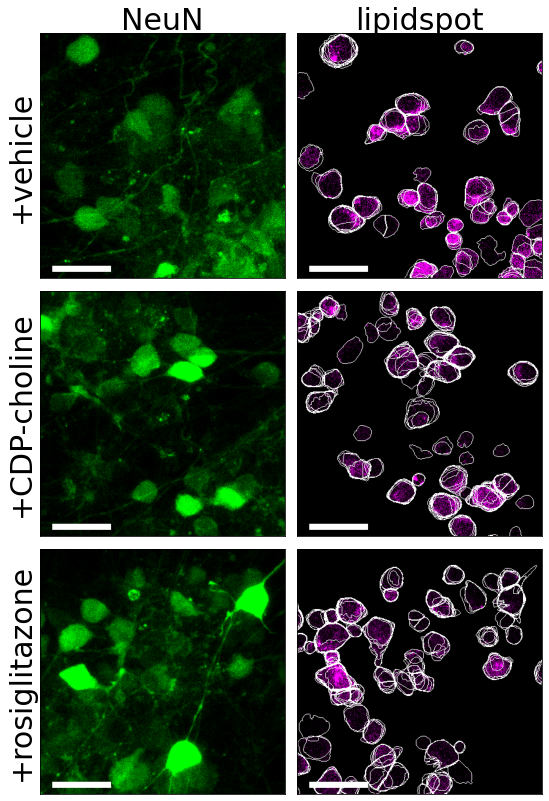

In [13]:
conditions = rep
fig, axes = plt.subplots(3, 2, figsize=(9, 14))#figsize=(27, 40))
fig.subplots_adjust(hspace=0.05, wspace=0.05)  # Adjust the spacing

for i in range(len(rep)):
    ID = conditions[i]
    mask_sele, mat_sele = load_im_from_memmap(ID, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    mat_sele = extract_channels([0,1,2], mat_sele)

    plt1 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict2, channels=[1], order=[2,1,0], mask_channel = [2], maskit=False, percentile=percentile)
    
    d = impose_segmentation(mask_sele, np.zeros_like(mat_sele), val=1)

    plt2 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[2], order=[2,1,0], mask_channel = [2], maskit=True, percentile=percentile)
    plt2[:,:,2] = plt2[:,:,0]
    plt1[:,:,2] = plt1[:,:,0]
    
    d = np.max(d, axis=0)
    plt2[d==1]=1
    
    #T = np.mean(mask_sele, axis=0)>0
    #plt2[T,:] = 1
    
    # get image
    imgA = AICSImage(in_parent + files[ID])

    plot_axis(axes, plt1[y1[i]:y2[i],x1[i]:x2[i],:], i,0, 30, imgA, collabs, rowlabs)
    plot_axis(axes, plt2[y1[i]:y2[i],x1[i]:x2[i],:], i,1, 30, imgA, collabs, rowlabs)
    
fig.savefig('../out_ims/lipidspot.png')


In [25]:
# determine upper dict
ma_out = []
mas_out = []

for i in rep:
    mask_sele, mat_sele = load_im_from_memmap(i, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    ma_out.append(mat_sele)
    mas_out.append(mask_sele)
    
mat_sele = np.vstack(ma_out)
mask_sele = np.vstack(mas_out)
mat_sele = extract_channels([0,1,3], mat_sele)

nums = [99, 97, 94] 
upper_dict = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))

nums = [99, 98, 98] 
upper_dict2 = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))

lower_dict = {0: 0, 1: 0, 2: 0}
gamma_dict = {0: 1, 1: 1, 2: 1}

nums = [0,95,0]
background_dict = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))

percentile=False

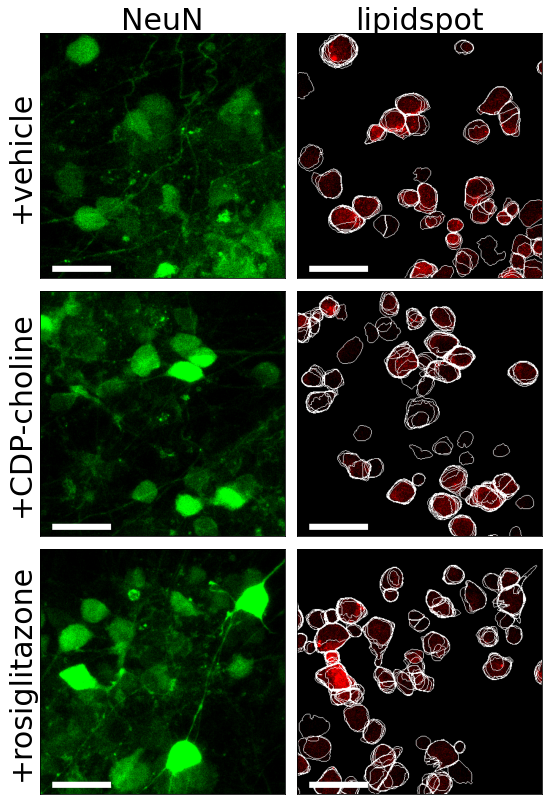

In [26]:
conditions = rep
fig, axes = plt.subplots(3, 2, figsize=(9, 14))#figsize=(27, 40))
fig.subplots_adjust(hspace=0.05, wspace=0.05)  # Adjust the spacing

for i in range(len(rep)):
    ID = conditions[i]
    mask_sele, mat_sele = load_im_from_memmap(ID, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    mat_sele = extract_channels([0,1,3], mat_sele)

    plt1 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict2, channels=[1], order=[2,1,0], mask_channel = [2], maskit=False, percentile=percentile)
    
    d = impose_segmentation(mask_sele, np.zeros_like(mat_sele), val=1)

    plt2 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[2], order=[2,1,0], mask_channel = [2], maskit=True, percentile=percentile)
    #plt2[:,:,1] = plt2[:,:,0]
    #plt1[:,:,] = plt1[:,:,0]
    
    d = np.max(d, axis=0)
    plt2[d==1]=1
    
    #T = np.mean(mask_sele, axis=0)>0
    #plt2[T,:] = 1
    
    # get image
    imgA = AICSImage(in_parent + files[ID])

    plot_axis(axes, plt1[y1[i]:y2[i],x1[i]:x2[i],:], i,0, 30, imgA, collabs, rowlabs)
    plot_axis(axes, plt2[y1[i]:y2[i],x1[i]:x2[i],:], i,1, 30, imgA, collabs, rowlabs)
    
fig.savefig('../out_ims/plin2.png')


# Below is scrap

In [173]:
# determine upper dict
ma_out = []
mas_out = []

for i in rep:
    mask_sele, mat_sele = load_im_from_memmap(i, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    ma_out.append(mat_sele)
    mas_out.append(mask_sele)
    
mat_sele = np.vstack(ma_out)
mask_sele = np.vstack(mas_out)
mat_sele = extract_channels([1,2,3], mat_sele)

nums = [98, 99.5, 99.5] 
upper_dict = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))

nums = [98, 95.5, 99.5] 
upper_dict2 = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))

lower_dict = {0: 0, 1: 0, 2: 0}
gamma_dict = {0: .7, 1: 1, 2: 1}

nums = [90,99,99]
background_dict = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))

percentile=False

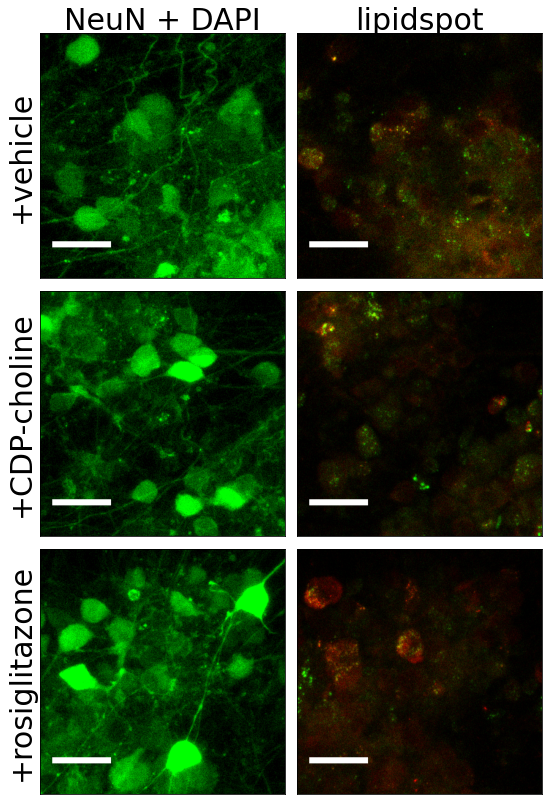

In [174]:
conditions = rep
fig, axes = plt.subplots(3, 2, figsize=(9, 14))#figsize=(27, 40))
fig.subplots_adjust(hspace=0.05, wspace=0.05)  # Adjust the spacing

for i in range(len(rep)):
    ID = conditions[i]
    mask_sele, mat_sele = load_im_from_memmap(ID, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    mat_sele = extract_channels([1,2,3], mat_sele)

    plt1 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict2, channels=[0], order=[2,0,1], mask_channel = [2], maskit=False, percentile=percentile)
    plt2 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[2,1], order=[2,1,0], mask_channel = [2], maskit=False, percentile=percentile)
    #plt2[:,:,2] = plt2[:,:,0]
    #plt1[:,:,2] = plt1[:,:,0]
    
    # get image
    imgA = AICSImage(in_parent + files[ID])

    plot_axis(axes, plt1[y1[i]:y2[i],x1[i]:x2[i],:], i,0, 30, imgA, collabs, rowlabs)
    plot_axis(axes, plt2[y1[i]:y2[i],x1[i]:x2[i],:], i,1, 30, imgA, collabs, rowlabs)
    


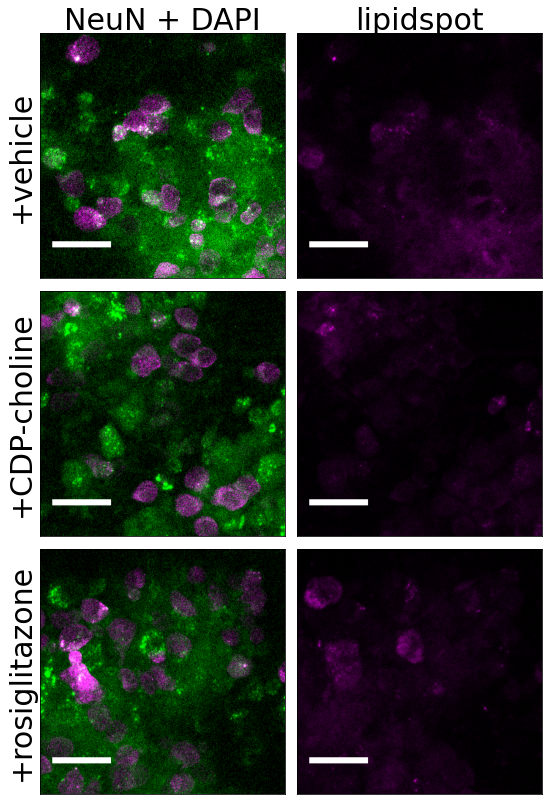

In [163]:
conditions = rep
fig, axes = plt.subplots(3, 2, figsize=(9, 14))#figsize=(27, 40))
fig.subplots_adjust(hspace=0.05, wspace=0.05)  # Adjust the spacing

for i in range(len(rep)):
    ID = conditions[i]
    mask_sele, mat_sele = load_im_from_memmap(ID, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    mat_sele = extract_channels([3,1,2], mat_sele)

    plt1 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict2, channels=[1,2], order=[2,1,0], mask_channel = [2], maskit=True, percentile=percentile)
    plt2 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[2], order=[2,1,0], mask_channel = [2], maskit=False, percentile=percentile)
    plt2[:,:,2] = plt2[:,:,0]
    plt1[:,:,2] = plt1[:,:,0]
    
    # get image
    imgA = AICSImage(in_parent + files[ID])

    plot_axis(axes, plt1[y1[i]:y2[i],x1[i]:x2[i],:], i,0, 30, imgA, collabs, rowlabs)
    plot_axis(axes, plt2[y1[i]:y2[i],x1[i]:x2[i],:], i,1, 30, imgA, collabs, rowlabs)
    


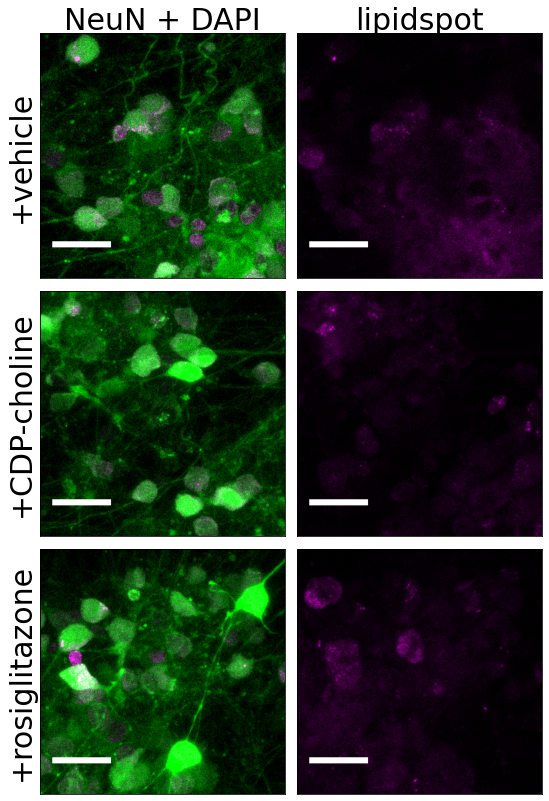

In [151]:
conditions = rep
fig, axes = plt.subplots(3, 2, figsize=(9, 14))#figsize=(27, 40))
fig.subplots_adjust(hspace=0.05, wspace=0.05)  # Adjust the spacing

for i in range(len(rep)):
    ID = conditions[i]
    mask_sele, mat_sele = load_im_from_memmap(ID, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    mat_sele = extract_channels([0,1,3], mat_sele)

    plt1 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict2, channels=[1,2], order=[2,1,0], mask_channel = [2], maskit=True, percentile=percentile)
    plt2 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[2], order=[2,1,0], mask_channel = [2], maskit=False, percentile=percentile)
    plt2[:,:,2] = plt2[:,:,0]
    plt1[:,:,2] = plt1[:,:,0]
    
    # get image
    imgA = AICSImage(in_parent + files[ID])

    plot_axis(axes, plt1[y1[i]:y2[i],x1[i]:x2[i],:], i,0, 30, imgA, collabs, rowlabs)
    plot_axis(axes, plt2[y1[i]:y2[i],x1[i]:x2[i],:], i,1, 30, imgA, collabs, rowlabs)
    


In [73]:
plt2[:,:,2] = plt2[:,:,0]

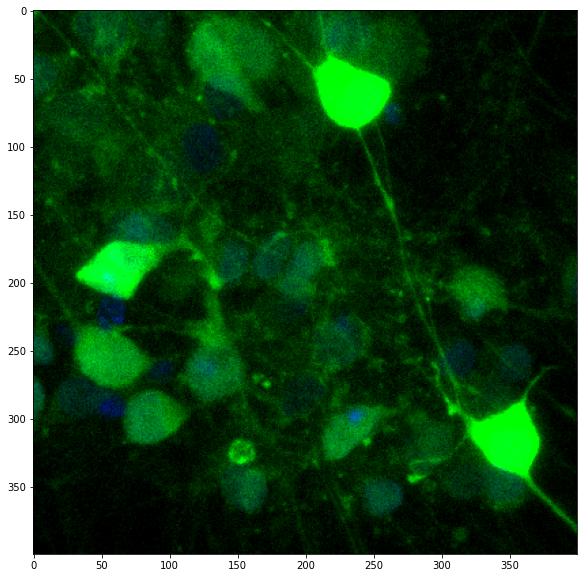

In [84]:
plt.figure(figsize=(10,10))
plt.imshow(plt1[600:1000,600:1000])